In [1]:
import numpy as np
import tensorflow as tf
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.utils import plot_model

1/1 [==============================] - 1s 1s/step
Predicted: [('n01665541', 'leatherback_turtle', 0.6798812)]


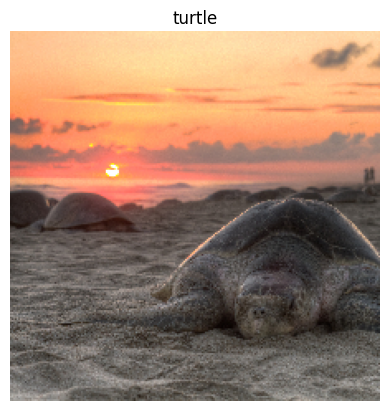

In [2]:
from matplotlib import pyplot as plt

model = MobileNetV2(weights='imagenet')

img_path = "..\\turtle.jpg"""
img = image.load_img(img_path, target_size=(224, 224), keep_aspect_ratio=True)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.convert_to_tensor(preprocess_input(x))

preds = model.predict(x)

# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=1)[0])
plt.figure()
plt.imshow(img)
plt.axis('off')
plt.title("turtle")
plt.show()

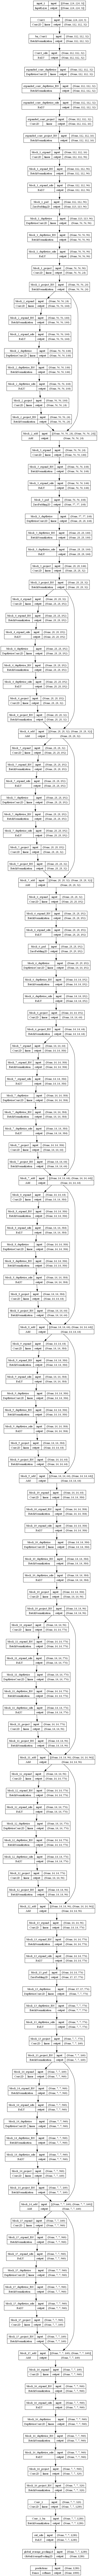

In [3]:
plot_model(model, show_layer_names=True, show_shapes=True, show_layer_activations=True)

In [3]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [4]:
for i in range(len(model.layers)):
    print(str(i) + ":", model.get_layer(index=i))

0: <keras.src.engine.input_layer.InputLayer object at 0x000001987020E190>
1: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x00000198704799D0>
2: <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x00000198705AB5D0>
3: <keras.src.layers.activation.relu.ReLU object at 0x00000198705A9D10>
4: <keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x0000019870787210>
5: <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x00000198704B3A10>
6: <keras.src.layers.activation.relu.ReLU object at 0x0000019870787850>
7: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000019870797690>
8: <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x00000198704F7DD0>
9: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x00000198707AE7D0>
10: <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x00000198707A4FD0>
11: <keras.src.layers.activati

In [46]:
from mobilenetv2.utils import split_functional_model

head, tail = split_functional_model(model, 20)

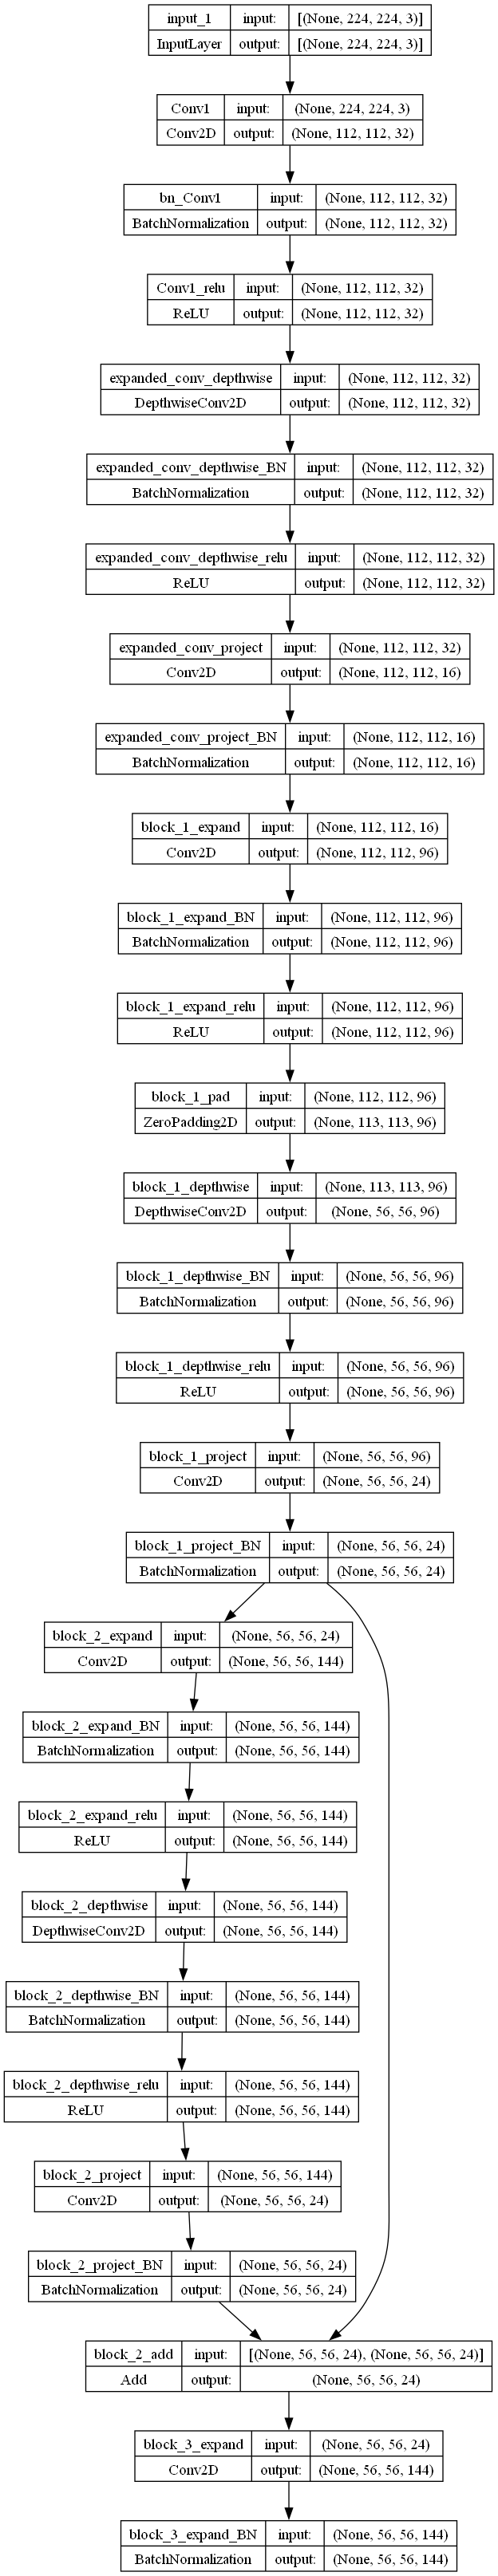

In [47]:
plot_model(head, show_layer_names=True, show_shapes=True)

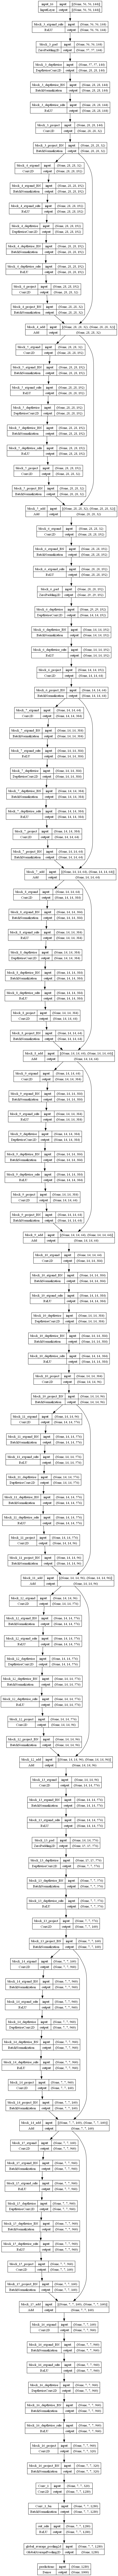

In [48]:
plot_model(tail, show_layer_names=True, show_shapes=True)

In [4]:
inter = head.predict(x)
out = tail.predict(inter)
print('Predicted:', decode_predictions(preds, top=5)[0])
print('Predicted:', decode_predictions(out, top=5)[0])

1/1 [==============================] - 0s 366ms/step
Predicted: [('n01665541', 'leatherback_turtle', 0.67987937), ('n01664065', 'loggerhead', 0.060382016), ('n02504013', 'Indian_elephant', 0.04116459), ('n02398521', 'hippopotamus', 0.013183607), ('n02504458', 'African_elephant', 0.011403109)]
Predicted: [('n01665541', 'leatherback_turtle', 0.67987937), ('n01664065', 'loggerhead', 0.060382016), ('n02504013', 'Indian_elephant', 0.04116459), ('n02398521', 'hippopotamus', 0.013183607), ('n02504458', 'African_elephant', 0.011403109)]


In [165]:
def representative_dataset():
    for _ in range(100):
        data = np.random.rand(1, 224, 224, 3)
        yield [data.astype(np.float32)]


In [166]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_model = converter.convert()

# Save the model.
with open('full_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\danie\AppData\Local\Temp\tmpjqm0xf2q\assets


INFO:tensorflow:Assets written to: C:\Users\danie\AppData\Local\Temp\tmpjqm0xf2q\assets
C:\Users\danie\tuWien\10_semester\tensorflow\venv\Lib\site-packages\tensorflow\lite\python\convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [16]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

In [25]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.int8)
input_data = tf.image.convert_image_dtype(x, dtype=tf.int8)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print('Predicted:', decode_predictions(output_data, top=5)[0])

Predicted: [('n03788365', 'mosquito_net', -120), ('n15075141', 'toilet_tissue', -121), ('n03291819', 'envelope', -121), ('n04476259', 'tray', -124), ('n04209239', 'shower_curtain', -124)]


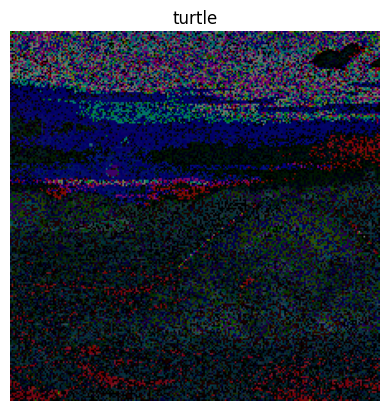

In [37]:
plt.figure()
plt.imshow(input_data[0])
plt.axis('off')
plt.title("turtle")
plt.show()

In [40]:
import tensorflow_datasets as tfds

ImportError: cannot import name 'core' from partially initialized module 'tensorflow_datasets' (most likely due to a circular import) (C:\Users\danie\tuWien\10_semester\tensorflow\venv\Lib\site-packages\tensorflow_datasets\__init__.py)

In [ ]:
test_ds = tfds.load('mnist', split=['train', 'test[:50%]'])